In [10]:
import typing as T

from dataclasses import dataclass
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import xml
import xml.etree
import xml.etree.ElementTree

import hashlib
import shutil
import json
import math
import cv2
import os

@dataclass
class Segment:
    xmin: int;
    ymin: int;
    xmax: int;
    ymax: int;
    name: str;
    pose: str;
    # Not always present in dataset, so I just set to "None"
    segmented: int;
    truncated: int;
    difficult: int;

@dataclass
class Image:
    img_path: str;
    xml_path: str;
    xml_data: any;
    b_boxes:  T.List[Segment];



def get_images(i_dir: str, img_ext = ".JPG") -> T.List[Image]:
    """
    Returns all images within a directory (not recursive?)
    The code for figuring out if the rotation is correct is in a later block, but just check if xml size is equal to the opencv size, and rotate if not
    """
    images: T.List[Image] = [];

    entries = os.listdir(i_dir); # Throws if doesn't exist
    for file in entries:
        if (not file.endswith(".xml")): continue;

        xml_pth = os.path.join(i_dir, file);
        xml_data = xml.etree.ElementTree.parse(xml_pth);

        img_file = os.path.splitext(file)[0] + img_ext;
        if (not (img_file in entries)): continue;

        # Read boxes from the xml
        b_boxes: T.List[Segment] = [];

        for box in xml_data.findall("object"):
            bnd_box = box.find("bndbox");
            b_boxes.append(Segment(
                xmin=math.floor(float(bnd_box.findtext("xmin"))),
                ymin=math.floor(float(bnd_box.findtext("ymin"))),
                xmax=math.floor(float(bnd_box.findtext("xmax"))),
                ymax=math.floor(float(bnd_box.findtext("ymax"))),
                name=box.findtext("name"),
                pose=box.findtext("pose"),
                segmented=None,
                truncated=int(box.findtext("truncated")),
                difficult=int(box.findtext("difficult"))
            ));

        # We now have an XML+image pair so add it to our collection
        images.append(Image(
            img_path=os.path.join(os.path.basename(i_dir), img_file),
            xml_path=xml_pth,
            xml_data=xml_data,
            b_boxes=b_boxes
        ));
    
    return images;


In [11]:
#
# This notebook should be in the path "repo/converting_datasets/hicks.ipynb"
#   The Hicks dataset should be the path "repo/datasets/hicks/"
#   The Hicks dataset (traintogoin.7z and validation.7z) can be aquired from https://doi.org/10.5061/dryad.63xsj3v34 (Hicks et al., 2021a)


dataset_pth = "../datasets/hicks/";
images: T.List[Image] = get_images(os.path.join(dataset_pth, "traintogoin")) + get_images(os.path.join(dataset_pth, "validation"));

# Shuffle our images
np.random.shuffle(images);

len(images)

2099

In [12]:
# Check that we have data in the format we expect
images[0].xml_data.findall("object")[0].findtext("name")

'Raununculus spp.'

In [13]:
def cv_write_text(cv_image: cv2.typing.MatLike, text, org,
    color=(0,0,0),
    fontFace=cv2.FONT_HERSHEY_PLAIN,
    fontScale=4.25,
    thickness=5) -> None:
    """Writes text onto an image"""
    cv2.putText(cv_image,
        text=text,
        org=org,
        fontFace=fontFace,
        fontScale=fontScale,
        thickness=thickness,
        color=color
    );

def c_from_name(name: str, for_numpy = False, rgb=False) -> T.List[int]:
    """Get a colour from a hash"""
    # The python function "hash" does not give consistent results: https://stackoverflow.com/a/70498449
    hsh = int.from_bytes(hashlib.shake_128(name.encode(), usedforsecurity=False).digest(8), byteorder="big", signed=True);
    colour = ( math.floor(hsh / 256**2) % 255, math.floor(hsh / 256**3) % 255, math.floor(hsh / 256**4) % 255 );
    if (rgb or for_numpy): colour = ( colour[2], colour[1], colour[0] );
    
    if (not for_numpy): return colour
    else:
        return ( colour[0] / 256, colour[1] / 256, colour[2] / 256 );

In [14]:

img_size: T.Dict[T.Tuple[int], int] = {};
img_area: T.Dict[int, int]          = {};
species: T.Dict[str, int]           = {};
tags_p_img: T.Dict[int, int]        = {};

def inc_species(s_name: str) -> None:
    if (species.get(s_name) != None): species[s_name] += 1;
    else: species[s_name]                              = 1;

def inc_t_p_img(tags: str) -> None:
    if (tags_p_img.get(tags) != None): tags_p_img[tags] += 1;
    else:                              tags_p_img[tags]  = 1;

def inc_imgdeets(size: T.Tuple[int]) -> None:
    assert(len(size) == 2);

    area = np.prod(size);
    if (img_area.get(area) != None): img_area[area] += 1;
    else:                            img_area[area]  = 1;
    
    if (img_size.get(size) != None): img_size[size] += 1;
    else:                            img_size[size]  = 1;

# Make a dataset

,species,count
12,Leucanthemum vulgare,2868
0,Raununculus spp.,2214
10,Heracleum sphondylium,1948
11,Silene dioica/latifolia,1604
1,Trifolium repens,1507
9,Cirsium arvense,1462
18,Stachys sylvatica,1208
16,Rubus fruticosus agg.,1126
21,Vicia cracca,1097
3,yellow composite,1039


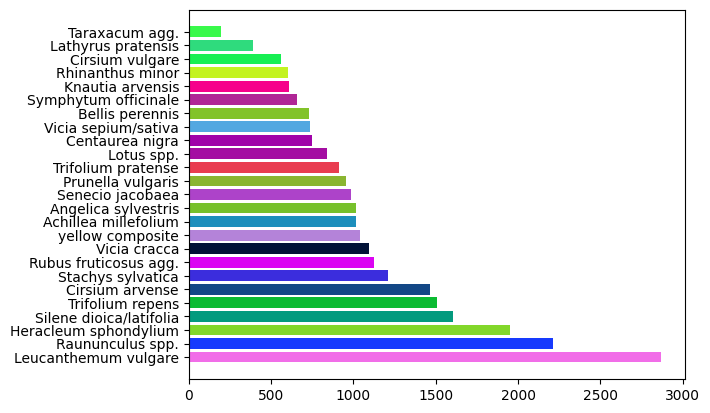

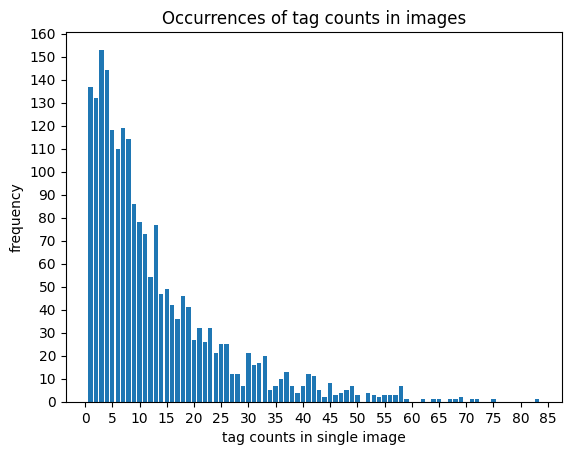

In [15]:
# We need to know some things
species: T.Dict[str, int]           = {};
tags_p_img: T.Dict[int, int]        = {};

def inc_species(s_name: str) -> None:
    if (species.get(s_name) != None): species[s_name] += 1;
    else: species[s_name]                              = 1;

def inc_t_p_img(tags: str) -> None:
    if (tags_p_img.get(tags) != None): tags_p_img[tags] += 1;
    else:                              tags_p_img[tags]  = 1;


#
# Process all the images' tags
#

for i, img in enumerate(images):

    # Count of tags
    inc_t_p_img(len(img.b_boxes));

    for box in img.b_boxes:
        # We don't care about this class
        if (box.name == "other spp."): continue;
        
        # Record an occurrence of a class
        inc_species(box.name);

species_df = pd.DataFrame(data={"species": species.keys(), "count": species.values()}).sort_values("count", ascending=False);
t_p_img_df = pd.DataFrame(data={"tags": tags_p_img.keys(), "count": tags_p_img.values()}).sort_values("count", ascending=False);

display(species_df);
# display(t_p_img_df);
plt.barh(y=species_df["species"], width=species_df["count"], color=[ c_from_name(s, True) for s in species_df["species"] ] );
plt.show();

# Distribution of tags/image
plt.bar(t_p_img_df["tags"], t_p_img_df["count"]);
plt.xlabel("tag counts in single image");
plt.ylabel("frequency");
plt.xticks(np.arange(0, 90, 5));
plt.yticks(np.arange(0, 170, 10));
plt.title("Occurrences of tag counts in images");
plt.plot();

In [16]:
#
# Now we know what species we have, we can create our subset
#

# The count of classes we want in our dataset
class_count = 9;
# How many images we want (maximum)
target_image_count = 300000;
# Require each image to have at least one instance of this many classes in the class list
minimum_classes = 1;
# Require an image to have at least this many tags
minimum_tags = 0;
# Ratio of random images to insert without doing checks(pseudo-distractor ratio)
# no_check_ratio = 0.1;
# Directory to store the new dataset
json_ds_dir = os.path.abspath(os.path.join(dataset_pth, "../hicks_json"));
# Where we should store images with bounding box infos
boxed_dir = os.path.abspath(os.path.join(json_ds_dir, "boxed_imgs"));



# Pick the most occuring classes
classes = list(species_df["species"][0:class_count-1].values);
print(f"{len(classes)} classes chosen for dataset {classes}");

# Create directories

def rm_then_mkdir(pth):
    if (os.path.exists(pth)):
        # rm -r in python taken from https://stackoverflow.com/a/43757091
        shutil.rmtree(pth);

    os.mkdir(pth);

rm_then_mkdir(json_ds_dir);
rm_then_mkdir(boxed_dir);

8 classes chosen for dataset ['Leucanthemum vulgare', 'Raununculus spp.', 'Heracleum sphondylium', 'Silene dioica/latifolia', 'Trifolium repens', 'Cirsium arvense', 'Stachys sylvatica', 'Rubus fruticosus agg.']


In [17]:
# Define a struct for the dataset json used in Adrian's code

@dataclass
class A_Annotation:
    # ID of this annotation?
    id: int;
    # ID of the relevant image
    image_id: int;
    # List of 4 ints
    bbox: T.List[int];
    # Id of the category
    category_id: int;

    # This is seemingly always 1.0
    # Need to look further into code
    area: float;
    # Unsure
    iscrowd: int;

@dataclass
class A_Category:
    # ID of category
    id: int;
    name: str;
    supercategory: str;

@dataclass
class A_Image:
    id: int;
    file_name: str;
    width: int;
    height: int;
    
@dataclass
class A_Dataset:
    annotations: T.List[A_Annotation];
    categories: T.List[A_Category];
    images: T.List[A_Image];



In [18]:
# 
# Select our dataset and construt it
#    Also create the boxed images
# 

import random

potential_images = [];

for i, img in enumerate(images):

    # Check if we've reached our target
    if (len(potential_images) >= target_image_count): break;

    # Before we load the image data, check if this image meets the criterion
    if (minimum_tags >= len(img.b_boxes)): continue;

    contained_classes = [];

    for box in img.b_boxes:
        # We don't care about this class
        if (box.name == "other spp."): continue;
        
        # Check if we have any occurence of a relevant class
        if ((box.name in classes) and (box.name not in contained_classes)):
            contained_classes.append(box.name);

    # Check to see if there are enough occurences of one of our classes
    if (minimum_classes > len(contained_classes)): continue;

    # Check if this image has the size we want (we still need to check if it needs rotating)
    cv_image = cv2.imread(os.path.join(dataset_pth, img.img_path));
    # Try to approximate if we've received a flipped image
    # XML width/height inverted compared to OpenCV
    img_d_size = (int(img.xml_data.find("size").findtext("height")), int(img.xml_data.find("size").findtext("width")));
    d_landscape = 1 < (img_d_size[0] / img_d_size[1]);
    i_landscape = 1 < (cv_image.shape[0] / cv_image.shape[1]);
    has_rotated_image = False;

    if (d_landscape != i_landscape):
        cv_image = cv2.rotate(cv_image, cv2.ROTATE_90_COUNTERCLOCKWISE);
        has_rotated_image=True;

    if (cv_image.shape != (2112, 2816, 3)): continue;

    # We've met all the criteria
    potential_images.append(img);


print(f"Found {len(potential_images)}/{target_image_count} valid images of target count");

Found 1174/300000 valid images of target count


In [19]:
# Construct the dataset

# Create the dataset and add the categories
ads = A_Dataset([], [], []);

for i, sp in enumerate(classes):
    ads.categories.append( A_Category(i, sp, sp) );

bbox_id = 0;

selected_images = [];

for img_id, img in enumerate(potential_images):
    if (not os.path.isdir( os.path.dirname( os.path.join(json_ds_dir, img.img_path) ) )):
        os.mkdir(os.path.dirname( os.path.join(json_ds_dir, img.img_path) ));
    
    cv_image = cv2.imread(os.path.join(dataset_pth, img.img_path));

    # Try to approximate if we've received a flipped image
    # XML width/height inverted compared to OpenCV
    img_d_size = (int(img.xml_data.find("size").findtext("height")), int(img.xml_data.find("size").findtext("width")));
    d_landscape = 1 < (img_d_size[0] / img_d_size[1]);
    i_landscape = 1 < (cv_image.shape[0] / cv_image.shape[1]);
    has_rotated_image = False;

    if (d_landscape != i_landscape):
        cv_image = cv2.rotate(cv_image, cv2.ROTATE_90_COUNTERCLOCKWISE);
        has_rotated_image=True;

    # Save both rotated images and non-roated images
    cv2.imwrite( os.path.join(json_ds_dir, img.img_path), cv_image);

    # Create entries in our new dataset format
    ads.images.append(A_Image(
        img_id,
        img.img_path,
        cv_image.shape[1],
        cv_image.shape[0]
    ));

    # Add this image's bounding boxes to the dataset
    density_bboxes = [];
    for bbox in img.b_boxes:
        if ( bbox.name not in classes ): continue;
        
        class_index = classes.index(bbox.name);
        # density_bboxes[class_index].append([bbox.xmin, bbox.ymin]);
        # density_bboxes[class_index].append([bbox.xmax, bbox.ymax]);
        ads.annotations.append(A_Annotation(
            id=bbox_id,
            image_id=img_id,
            bbox=[ bbox.xmin, bbox.ymin, bbox.xmax, bbox.ymax ],
            category_id=class_index,
            area=1.0,
            iscrowd=0
        ));
        
        bbox_id += 1;
    
        # Save bounding box data for density generation
        # REFER TO https://github.com/VisDrone/VisDrone2018-DET-toolkit
        # <bbox_left>,<bbox_top>,<bbox_width>,<bbox_height>,<score>,<object_category>,<truncation>,<occlusion>
        density_bboxes.append([
            bbox.xmin,
            bbox.ymin,
            bbox.xmax - bbox.xmin,
            bbox.ymax - bbox.ymin,
            1, # Score, ignored
            class_index,
            0, # ignored
            0  # ignored
        ]);

    pd.DataFrame(density_bboxes).to_csv(os.path.join(json_ds_dir, img.img_path.replace(".JPG", "")) + ".txt", header=False, index=False);


    #
    # Create "boxed" images
    #
    for box in img.b_boxes:
        # Get a unique colour for this species
        name_c = c_from_name(box.name);
        
        # Draw a bounding box
        cv2.rectangle(
            cv_image,
            pt1=(box.xmin, box.ymin),
            pt2=(box.xmax, box.ymax),
            color=name_c,
            thickness=8
        );
        # Annotate the box
        text_size = cv2.getTextSize( box.name if (box.name in classes) else "NOT COUNTED",fontFace=cv2.FONT_HERSHEY_PLAIN,fontScale=4.25,thickness=5)[0];
        cv2.rectangle(
            cv_image,
            pt1=(box.xmin, box.ymin - text_size[1]),
            pt2=(box.xmin + text_size[0], box.ymin),
            color=name_c,
            thickness=-1
        );
        cv_write_text(cv_image, box.name if (box.name in classes) else "NOT COUNTED", org=(box.xmin, box.ymin), color=(name_c[0]^255, name_c[1]^255, name_c[2]^255)); # Bitwise not the colour for text

        
    if (not os.path.isdir( os.path.dirname( os.path.join(boxed_dir, img.img_path) ) )):
        os.mkdir(os.path.dirname( os.path.join(boxed_dir, img.img_path) ));
    
    # Save bounding box image
    cv2.imwrite(os.path.join(boxed_dir, img.img_path + ".boxed.jpg"), cv_image);
    selected_images.append(os.path.join(json_ds_dir, img.img_path.replace(".JPG", "")));


In [20]:
json_ds_handle = open(os.path.join( json_ds_dir, "dataset.json" ), "w");

# JSON serialise class solution from this S/O comment: https://stackoverflow.com/questions/10252010/serializing-class-instance-to-json#comment82536156_10252010
json_ds_handle.write(json.dumps(ads, default=lambda x: x.__dict__, indent=4));
json_ds_handle.close();

In [21]:
# # Training splits

# def make_json_list(name: str, images):
#     imlist = [];

#     for img in images:
#         imlist.append(img.img_path);

#     json_ds_handle = open(os.path.join( json_ds_dir, name ), "w");

#     # JSON serialise class solution from this S/O comment: https://stackoverflow.com/questions/10252010/serializing-class-instance-to-json#comment82536156_10252010
#     json_ds_handle.write(json.dumps(imlist, default=lambda x: x.__dict__, indent=4));
#     json_ds_handle.close();
#     print(f"{name}: {len(imlist)}")


# img_count = len(potential_images);
# train_max = math.ceil(img_count * 0.7);
# test_max  = math.ceil(img_count * 0.2) + train_max;
# val_max   = img_count;

# make_json_list("json_train_set.json", potential_images[0:train_max]);
# make_json_list("json_test_set.json", potential_images[train_max:test_max]);
# make_json_list("json_val_set.json", potential_images[test_max:val_max]);

In [22]:
import shutil

# Modify paths to look like VisDrone
vdlike_ds_dir        = os.path.abspath(os.path.join(dataset_pth, "../hicks_vdlike"));
vdlike_ds_dir_trn    = os.path.join(vdlike_ds_dir, "train");
vdlike_ds_dir_val    = os.path.join(vdlike_ds_dir, "val");

vdlike_ds_dir_trn_an = os.path.join(vdlike_ds_dir_trn, "annotations");
vdlike_ds_dir_trn_im = os.path.join(vdlike_ds_dir_trn, "images");
vdlike_ds_dir_val_an = os.path.join(vdlike_ds_dir_val, "annotations");
vdlike_ds_dir_val_im = os.path.join(vdlike_ds_dir_val, "images");


rm_then_mkdir(vdlike_ds_dir);
os.mkdir(vdlike_ds_dir_trn);
os.mkdir(vdlike_ds_dir_val);
os.mkdir(vdlike_ds_dir_trn_an);
os.mkdir(vdlike_ds_dir_trn_im);
os.mkdir(vdlike_ds_dir_val_an);
os.mkdir(vdlike_ds_dir_val_im);

# Follow VisDrone split for train & val (6471 vs 548 ~92% so we make it an even 10%)
images_train = selected_images[ 0: int(len(selected_images)*0.9) ];
images_val   = selected_images[ int(len(selected_images)*0.9): ];
print(f"Training: {len(images_train)}, validation: {len(images_val)}, total images: {len(selected_images)}, bounding boxes counted: {bbox_id+1}");

Training: 1056, validation: 118, total images: 1174, bounding boxes counted: 13104


In [23]:
for img in images_val:
    img_name = os.path.basename(img);

    os.symlink(img+".txt", os.path.join(vdlike_ds_dir_val_an, img_name)+".txt");
    os.symlink(img+".JPG", os.path.join(vdlike_ds_dir_val_im, img_name)+".jpg");

for img in images_train:
    img_name = os.path.basename(img);

    os.symlink(img+".txt", os.path.join(vdlike_ds_dir_trn_an, img_name)+".txt");
    os.symlink(img+".JPG", os.path.join(vdlike_ds_dir_trn_im, img_name)+".jpg");